# COMPAS Recidivism Prediction Analysis
## A Beginner's Guide to Building and Evaluating Fair ML Models

### Introduction
This notebook analyzes the COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) dataset to:
1. Build a recidivism prediction model
2. Evaluate fairness across different demographic groups
3. Compare different ML algorithms

**What is recidivism?** Whether someone will commit another crime within 2 years

**Our goal:** Build a fair model that predicts recidivism accurately

## Part 1: Building the Model

### Step 1: Import Required Libraries

In [1]:
# Import all necessary packages
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully!")

Libraries imported successfully!


### Step 2: Load and Understand the Data

In [2]:
# Load the COMPAS dataset directly from GitHub
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/refs/heads/master/compas-scores-two-years-violent.csv'
df = pd.read_csv(url)
#Load the dataset locally if you have it
# df = pd.read_csv('path_to_your_local_file.csv')
print(f"Dataset shape: {df.shape}")
print(f"Number of records: {len(df)}")
print(f"Number of features: {len(df.columns)}")

# View first few rows
print("\nFirst 5 rows of data:")
df.head()

Dataset shape: (4743, 54)
Number of records: 4743
Number of features: 54

First 5 rows of data:


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,1
2,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,0
3,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0
4,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,0


### Step 3: Clean the Data

We need to remove unreliable or incomplete records:

In [3]:
print("Data cleaning steps:")
print(f"Starting with {len(df)} records")

# Step 1: Keep only cases where arrest and screening dates are within 30 days
df = df[df['days_b_screening_arrest'] <= 30]
df = df[df['days_b_screening_arrest'] >= -30]
print(f"After date filtering: {len(df)} records")

# Step 2: Remove cases where we couldn't find recidivism data
df = df[df['is_recid'] != -1]
print(f"After removing missing recidivism: {len(df)} records")

# Step 3: Remove traffic offenses (they don't lead to jail time)
df = df[df['c_charge_degree'] != "O"]
print(f"After removing traffic offenses: {len(df)} records")

# Step 4: Remove rows without risk scores
df = df[df['score_text'] != "N/A"]
print(f"Final dataset: {len(df)} records")

Data cleaning steps:
Starting with 4743 records
After date filtering: 4020 records
After removing missing recidivism: 4020 records
After removing traffic offenses: 4020 records
Final dataset: 4020 records


### Step 4: Explore the Data

Let's understand our key variables:

In [4]:
# Let's understand our key variables
print("Key Variables in Our Analysis:")
print("-" * 40)
print("1. two_year_recid: Did they reoffend within 2 years? (0=No, 1=Yes)")
print(f"   - No recidivism: {(df['two_year_recid']==0).sum()} ({(df['two_year_recid']==0).mean()*100:.1f}%)")
print(f"   - Recidivism: {(df['two_year_recid']==1).sum()} ({(df['two_year_recid']==1).mean()*100:.1f}%)")

print("\n2. Race distribution:")
print(df['race'].value_counts())

print("\n3. Criminal history features we'll use:")
print("   - juv_fel_count: Juvenile felony count")
print("   - juv_misd_count: Juvenile misdemeanor count")
print("   - juv_other_count: Other juvenile offenses")
print("   - priors_count: Adult prior offenses")

Key Variables in Our Analysis:
----------------------------------------
1. two_year_recid: Did they reoffend within 2 years? (0=No, 1=Yes)
   - No recidivism: 3368 (83.8%)
   - Recidivism: 652 (16.2%)

2. Race distribution:
race
African-American    1918
Caucasian           1459
Hispanic             355
Other                255
Asian                 26
Native American        7
Name: count, dtype: int64

3. Criminal history features we'll use:
   - juv_fel_count: Juvenile felony count
   - juv_misd_count: Juvenile misdemeanor count
   - juv_other_count: Other juvenile offenses
   - priors_count: Adult prior offenses


### Step 5: Prepare Features and Target

In [5]:
# Select features (X) and target (y)
feature_columns = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count"]
X = df[feature_columns]
y = df['two_year_recid']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Quick look at feature statistics
print("\nFeature Statistics:")
X.describe()

Features shape: (4020, 4)
Target shape: (4020,)

Feature Statistics:


,juv_fel_count,juv_misd_count,juv_other_count,priors_count
count,4020.000000,4020.000000,4020.000000,4020.000000
mean,0.042786,0.067413,0.080597,2.445522
std,0.436754,0.404851,0.410695,3.952853
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,3.000000
max,20.000000,8.000000,7.000000,38.000000


### Step 6: Split Data for Training and Testing

In [6]:
# Split data: 70% for training, 30% for testing
X_trainset, X_testset, y_trainset, y_testset = train_test_split(
    X, y, test_size=0.3, random_state=3
)

print(f"Training set size: {len(X_trainset)} samples")
print(f"Test set size: {len(X_testset)} samples")
print(f"Recidivism rate in training: {y_trainset.mean()*100:.1f}%")
print(f"Recidivism rate in test: {y_testset.mean()*100:.1f}%")

Training set size: 2814 samples
Test set size: 1206 samples
Recidivism rate in training: 16.6%
Recidivism rate in test: 15.3%


### Step 7: Train a Decision Tree Model

In [7]:
# Create and train the decision tree
# max_depth=3 keeps the tree simple and interpretable
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=42)
clf = clf.fit(X_trainset, y_trainset)

print("Model trained successfully!")

Model trained successfully!


### Step 8: Make Predictions and Evaluate

In [8]:
# Make predictions on test set
y_pred = clf.predict(X_testset)

# Calculate accuracy
accuracy = accuracy_score(y_testset, y_pred)
print(f"Model Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")

# Show confusion matrix
cm = confusion_matrix(y_testset, y_pred)
print("\nConfusion Matrix:")
print("                 Predicted")
print("                 No   Yes")
print(f"Actual No     [{cm[0,0]:4d} {cm[0,1]:4d}]")
print(f"Actual Yes    [{cm[1,0]:4d} {cm[1,1]:4d}]")

# Visualize the decision tree
print("\nDecision Tree Structure:")
tree_rules = export_text(clf, feature_names=list(X.columns))
print(tree_rules)

Model Accuracy: 0.856 (85.6%)

Confusion Matrix:
                 Predicted
                 No   Yes
Actual No     [1012   10]
Actual Yes    [ 164   20]

Decision Tree Structure:
|--- priors_count <= 3.50
|   |--- priors_count <= 1.50
|   |   |--- priors_count <= 0.50
|   |   |   |--- class: 0
|   |   |--- priors_count >  0.50
|   |   |   |--- class: 0
|   |--- priors_count >  1.50
|   |   |--- juv_misd_count <= 1.50
|   |   |   |--- class: 0
|   |   |--- juv_misd_count >  1.50
|   |   |   |--- class: 1
|--- priors_count >  3.50
|   |--- juv_other_count <= 0.50
|   |   |--- priors_count <= 22.50
|   |   |   |--- class: 0
|   |   |--- priors_count >  22.50
|   |   |   |--- class: 1
|   |--- juv_other_count >  0.50
|   |   |--- juv_other_count <= 2.50
|   |   |   |--- class: 1
|   |   |--- juv_other_count >  2.50
|   |   |   |--- class: 1



### Step 9: Compare with COMPAS

In [9]:
# Convert COMPAS scores to binary (high risk = score > 5)
df['decile_score_binary'] = (df['decile_score'] > 5).astype(int)

# Get COMPAS predictions for our test set
y_compas = df["decile_score_binary"][y_testset.index]

# Compare predictions
agreement = accuracy_score(y_compas, y_pred)
print(f"Agreement between our model and COMPAS: {agreement:.3f} ({agreement*100:.1f}%)")

# Compare accuracies
our_accuracy = accuracy_score(y_testset, y_pred)
compas_accuracy = accuracy_score(y_testset, y_compas)
print(f"\nOur model accuracy: {our_accuracy:.3f}")
print(f"COMPAS accuracy: {compas_accuracy:.3f}")

Agreement between our model and COMPAS: 0.752 (75.2%)

Our model accuracy: 0.856
COMPAS accuracy: 0.757


## Part 2: Fairness Analysis

### Understanding Fairness Metrics

Before we start, let's understand what these metrics mean:

1. **Demographic Parity**: All groups should have similar positive prediction rates
2. **False Positive Rate**: Rate of incorrectly predicting recidivism for non-recidivists
3. **Equalized Odds**: Both true positive and false positive rates should be similar across groups

In [12]:
# Install fairlearn for fairness metrics
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/240.0 kB ? eta -:--:--Requirement already satisfied: threadpoolctl>=2.0.0 in /opt/anaconda3/lib/python3.11/site-packages (from scikit-learn>=1.2.1->fairlearn) (2.2.0)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 1.1 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 1.1 MB/s eta 0:00:00a 0:00:01


### Step 1: Calculate Demographic Parity

In [13]:
from fairlearn.metrics import demographic_parity_difference

# Get race information for test set
sensitive_feat = df['race'][y_testset.index]

# Calculate demographic parity difference
dpd = demographic_parity_difference(
    y_true=y_testset, 
    y_pred=y_pred, 
    sensitive_features=sensitive_feat
)

print(f"Demographic Parity Difference: {dpd:.3f}")
print("\nInterpretation:")
print("- Close to 0 = Fair (all races have similar positive prediction rates)")
print("- Positive = Some group has higher positive prediction rate")
print("- Negative = Some group has lower positive prediction rate")

Demographic Parity Difference: 0.037

Interpretation:
- Close to 0 = Fair (all races have similar positive prediction rates)
- Positive = Some group has higher positive prediction rate
- Negative = Some group has lower positive prediction rate


### Step 2: Analyze False Positive Rates by Race

In [14]:
from fairlearn.metrics import false_positive_rate, MetricFrame

# Calculate FPR for each racial group
fpr_frame = MetricFrame(
    metrics=false_positive_rate,
    y_true=y_testset,
    y_pred=y_pred,
    sensitive_features=sensitive_feat
)

print("False Positive Rates by Race:")
print("-" * 40)
print(fpr_frame.by_group.sort_values(ascending=False))
print(f"\nOverall FPR: {fpr_frame.overall:.3f}")

# Specific analysis for Black individuals
race_testset = df['race'][y_testset.index]
black_mask = race_testset == 'African-American'
if black_mask.any():
    y_true_black = y_testset[black_mask]
    y_pred_black = y_pred[black_mask]
    fpr_black = false_positive_rate(y_true_black, y_pred_black)
    
    print(f"\nDetailed Analysis for Black Individuals:")
    print(f"- FPR: {fpr_black:.3f}")
    print(f"- This means {fpr_black*100:.1f}% of Black non-recidivists are incorrectly")
    print(f"  predicted to reoffend (false alarms)")

False Positive Rates by Race:
----------------------------------------
race
Caucasian           0.013021
African-American    0.010941
Asian               0.000000
Hispanic            0.000000
Native American     0.000000
Other               0.000000
Name: false_positive_rate, dtype: float64

Overall FPR: 0.010

Detailed Analysis for Black Individuals:
- FPR: 0.011
- This means 1.1% of Black non-recidivists are incorrectly
  predicted to reoffend (false alarms)


### Step 3: Calculate Equalized Odds Difference

In [15]:
from fairlearn.metrics import equalized_odds_difference

# Calculate equalized odds difference
eod = equalized_odds_difference(
    y_true=y_testset,
    y_pred=y_pred,
    sensitive_features=sensitive_feat
)

print(f"Equalized Odds Difference: {eod:.3f}")
print("\nInterpretation:")
print("- Measures if the model is equally accurate for all races")
print("- Close to 0 = Fair (similar accuracy across races)")
print("- Larger values = Model performs differently across races")

Equalized Odds Difference: 0.140

Interpretation:
- Measures if the model is equally accurate for all races
- Close to 0 = Fair (similar accuracy across races)
- Larger values = Model performs differently across races


### Visualize Fairness Metrics

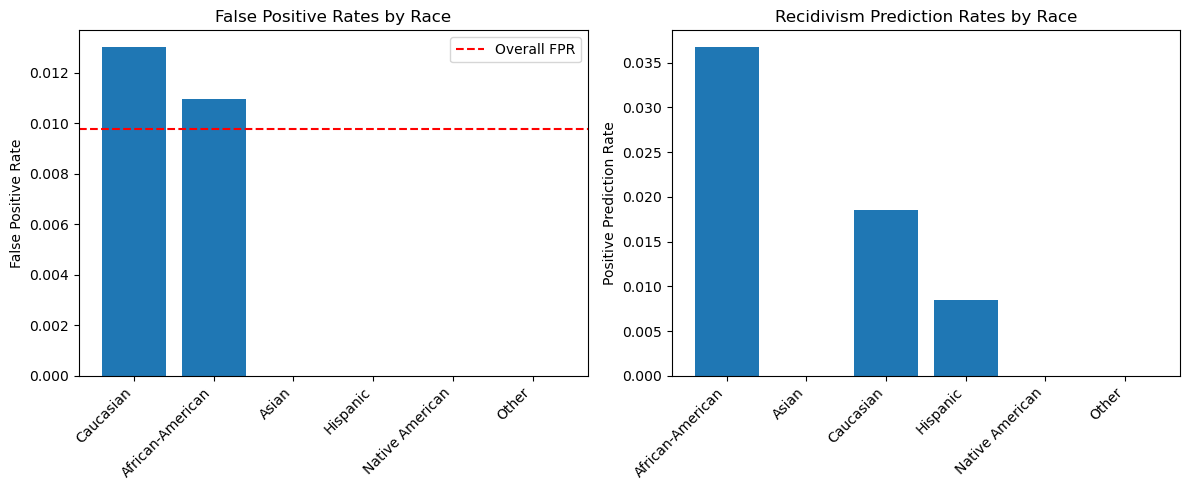

In [16]:
# Create a summary visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: FPR by race
fpr_data = fpr_frame.by_group.sort_values(ascending=False)
ax1.bar(range(len(fpr_data)), fpr_data.values)
ax1.set_xticks(range(len(fpr_data)))
ax1.set_xticklabels(fpr_data.index, rotation=45, ha='right')
ax1.axhline(y=fpr_frame.overall, color='r', linestyle='--', label='Overall FPR')
ax1.set_ylabel('False Positive Rate')
ax1.set_title('False Positive Rates by Race')
ax1.legend()

# Plot 2: Prediction rates by race
pred_rates = MetricFrame(
    metrics=lambda y_true, y_pred: y_pred.mean(),
    y_true=y_testset,
    y_pred=y_pred,
    sensitive_features=sensitive_feat
).by_group

ax2.bar(range(len(pred_rates)), pred_rates.values)
ax2.set_xticks(range(len(pred_rates)))
ax2.set_xticklabels(pred_rates.index, rotation=45, ha='right')
ax2.set_ylabel('Positive Prediction Rate')
ax2.set_title('Recidivism Prediction Rates by Race')

plt.tight_layout()
plt.show()

### Try Different Model Parameters

In [17]:
print("Let's see how changing the model affects fairness:")
print("-" * 50)

# Try different max_depth values
for depth in [2, 3, 5]:
    # Train model
    clf_test = tree.DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf_test.fit(X_trainset, y_trainset)
    y_pred_test = clf_test.predict(X_testset)
    
    # Calculate metrics
    accuracy = accuracy_score(y_testset, y_pred_test)
    dpd = demographic_parity_difference(y_true=y_testset, y_pred=y_pred_test, 
                                      sensitive_features=sensitive_feat)
    
    print(f"\nMax Depth = {depth}:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Demographic Parity Difference: {dpd:.3f}")

Let's see how changing the model affects fairness:
--------------------------------------------------

Max Depth = 2:
  Accuracy: 0.855
  Demographic Parity Difference: 0.028

Max Depth = 3:
  Accuracy: 0.856
  Demographic Parity Difference: 0.037

Max Depth = 5:
  Accuracy: 0.856
  Demographic Parity Difference: 0.040


## Part 3: Try Different Models

### Random Forest Model

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_trainset, y_trainset)

# Make predictions
y_pred_rf = rf_model.predict(X_testset)

# Evaluate
rf_accuracy = accuracy_score(y_testset, y_pred_rf)
rf_dpd = demographic_parity_difference(y_true=y_testset, y_pred=y_pred_rf, 
                                     sensitive_features=sensitive_feat)

print("Random Forest Results:")
print(f"Accuracy: {rf_accuracy:.3f}")
print(f"Demographic Parity Difference: {rf_dpd:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

Random Forest Results:
Accuracy: 0.847
Demographic Parity Difference: 0.019

Feature Importance:
           feature  importance
3     priors_count    0.637880
1   juv_misd_count    0.147355
2  juv_other_count    0.133445
0    juv_fel_count    0.081320


### Support Vector Machine

In [19]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# SVM needs scaled features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_trainset)
X_test_scaled = scaler.transform(X_testset)

# Train SVM
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_trainset)

# Predictions
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate
svm_accuracy = accuracy_score(y_testset, y_pred_svm)
svm_dpd = demographic_parity_difference(y_true=y_testset, y_pred=y_pred_svm, 
                                      sensitive_features=sensitive_feat)

print("SVM Results:")
print(f"Accuracy: {svm_accuracy:.3f}")
print(f"Demographic Parity Difference: {svm_dpd:.3f}")

SVM Results:
Accuracy: 0.849
Demographic Parity Difference: 0.018


### K-Nearest Neighbors

In [20]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_trainset)

# Predictions
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluate
knn_accuracy = accuracy_score(y_testset, y_pred_knn)
knn_dpd = demographic_parity_difference(y_true=y_testset, y_pred=y_pred_knn, 
                                      sensitive_features=sensitive_feat)

print("K-Nearest Neighbors Results:")
print(f"Accuracy: {knn_accuracy:.3f}")
print(f"Demographic Parity Difference: {knn_dpd:.3f}")

K-Nearest Neighbors Results:
Accuracy: 0.778
Demographic Parity Difference: 0.142


### Compare All Models

Model Comparison Summary:
           Model  Accuracy  Fairness (DPD)
0  Decision Tree     0.856           0.037
1  Random Forest     0.847           0.019
2            SVM     0.849           0.018
3            KNN     0.778           0.142


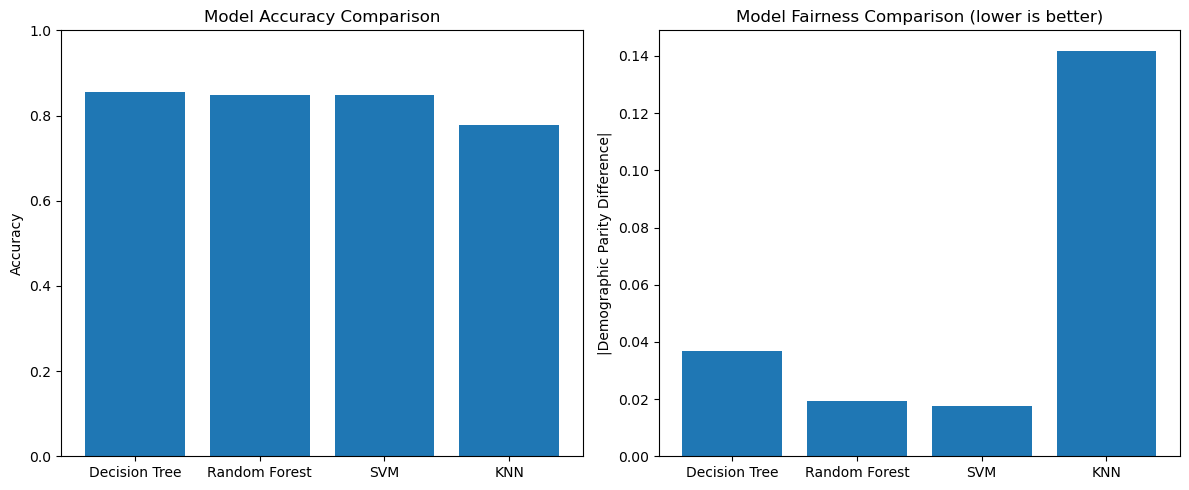

In [21]:
# Create comparison summary
models_comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'SVM', 'KNN'],
    'Accuracy': [accuracy, rf_accuracy, svm_accuracy, knn_accuracy],
    'Fairness (DPD)': [
        demographic_parity_difference(y_true=y_testset, y_pred=y_pred, sensitive_features=sensitive_feat),
        rf_dpd, svm_dpd, knn_dpd
    ]
})

print("Model Comparison Summary:")
print(models_comparison.round(3))

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
ax1.bar(models_comparison['Model'], models_comparison['Accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylim(0, 1)

# Fairness comparison
ax2.bar(models_comparison['Model'], models_comparison['Fairness (DPD)'].abs())
ax2.set_ylabel('|Demographic Parity Difference|')
ax2.set_title('Model Fairness Comparison (lower is better)')

plt.tight_layout()
plt.show()

## Summary and Key Takeaways

### What We Learned:

1. **Model Building**: We can predict recidivism using criminal history features
2. **Fairness Matters**: Models can have different impacts on different racial groups
3. **Trade-offs Exist**: Sometimes more accurate models are less fair

### Important Considerations:

1. **False Positives Matter**: Incorrectly labeling someone as high-risk can affect their freedom
2. **Historical Bias**: Training on biased historical data can perpetuate discrimination
3. **Multiple Metrics**: Look at both accuracy AND fairness metrics

### Questions to Think About:

1. Is it ethical to use race-blind features that might correlate with race?
2. Should we prioritize accuracy or fairness? Can we achieve both?
3. How might these predictions affect real people's lives?

### Next Steps:

1. Try adding more features (age, sex, charge type)
2. Experiment with fairness-aware algorithms
3. Consider the real-world impact of your model's decisions
